# Testing model fit with 3D molecule orientation

In [1]:
import os
import sys

import numpy as np

## Plotting stuff
import matplotlib.pyplot as plt
import matplotlib as mpl

## For colorbar 
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Get physical constants from Scipy
import scipy.constants as con

## For fitting
import scipy.optimize as opt

## For matlab loading
import scipy.io as sio

module_path = os.path.abspath(os.path.join('..', "..", ".."))
sys.path.append(module_path)
## Load custom package modules
from misloc_mispol_package.calc import BEM_simulation_wrapper as bem
from misloc_mispol_package.calc import fitting_misLocalization as fit
from misloc_mispol_package.calc import coupled_dipoles as cp
from misloc_mispol_package.optics import diffraction_int as diffi
from misloc_mispol_package.optics import fibonacci as fib

In [2]:
## Parameter setting needs to be in cell following mpl import for some reason 
## https://github.com/jupyter/notebook/issues/3385
##
## Default parameters inspired by 
## http://nipunbatra.github.io/2014/08/latexify/
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'magma',
    'axes.grid': False,
    'figure.dpi': 200,  # to adjust notebook inline plot size
    'savefig.dpi': 200,  # to adjust notebook inline plot size
#     'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 8, # was 10
#     'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 10, # fontsize for x and y labels (was 10)
    'axes.titlesize': 10,
    'font.size': 8, # was 10
    'legend.fontsize': 8, # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': True,
    'figure.figsize': [3.39, 2.10],
    'font.family': 'serif',
    'figure.max_open_warning':10001
}
mpl.rcParams.update(params)

In [3]:
## Some useful numerical constants
hbar = con.physical_constants['Planck constant over 2 pi in eV s'][0]
c = con.physical_constants['speed of light in vacuum'][0]*1e2 #cm/m

m_per_nm = fit.m_per_nm

eps_b = 1.778 ## Water
cm_per_nm = 1E-7

hres_obs_pts = diffi.observation_points(
    -480*m_per_nm, 480*m_per_nm, -480*m_per_nm, 480*m_per_nm, 201)

In [4]:
param_file = 'disk_70nm'
disk_radius = 70/2

## Set molecule positions 
num_per_arc = 3
## The angle and radii ranges must be defined as lists in order to 
## expand them below to get a spherical coordinate for each dipole.
angle_range = np.linspace(0, np.pi/2, num_per_arc).tolist()
radii_range = (np.array([10])+disk_radius).tolist()

number_of_mols = len(angle_range) * len(radii_range)

## Build list of angles for each molecule
angles = (angle_range)*len(radii_range)
## Build list of radii for each molecule
radii = [[val]*len(angle_range)for val in radii_range]
## Flatten
radii = [item for sublist in radii for item in sublist]

Calculating Gaussian centroid with analytic images


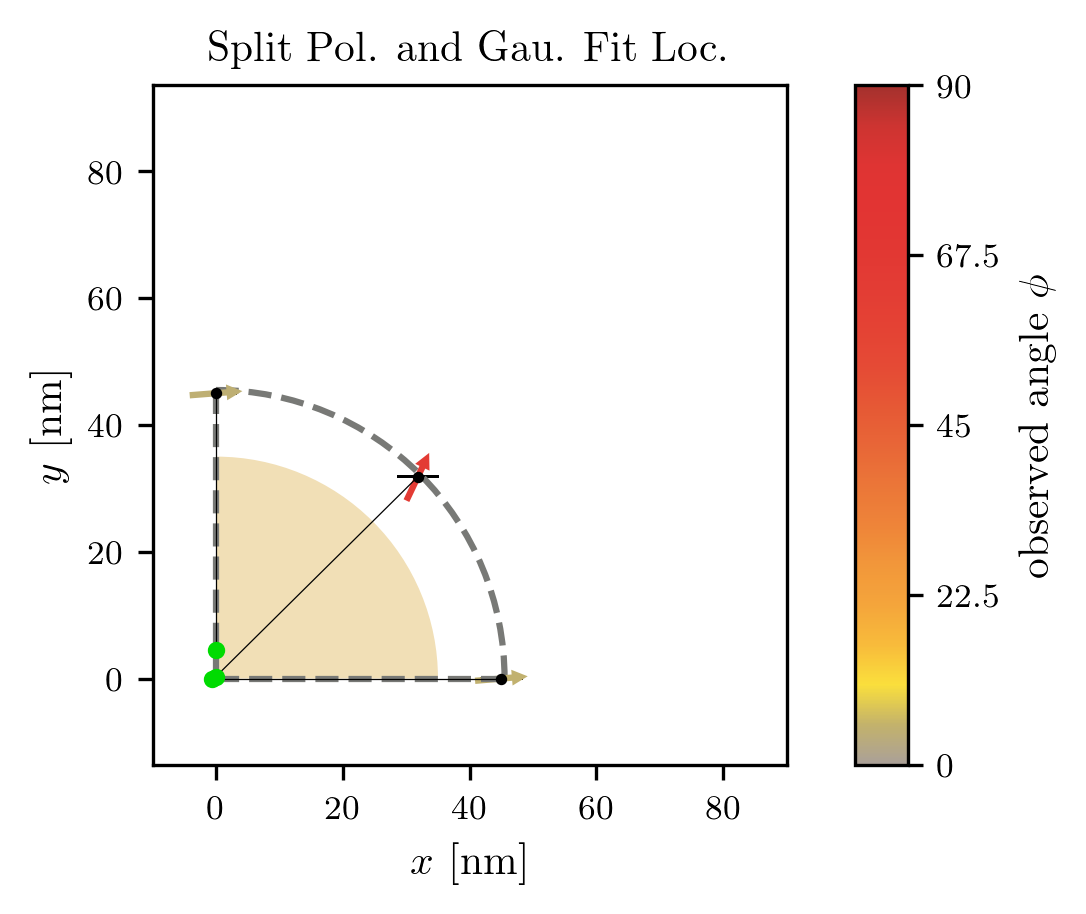

In [5]:
locations = fib.sphere_to_cart(
    thetas=np.ones(number_of_mols)*np.pi/2,
    phis=angles,
    rs=radii
    )

model_exp = fit.MolCoupNanoRodExp(
    locations, 
    mol_angle=np.array([0]),
    param_file=param_file,
    for_fit=True ## This turns of auto_quenching
    )
 
model_exp.quel_a = model_exp.true_a_un_me
model_exp.quel_c = model_exp.true_a_de_me

model_exp.plot_mispol_map_wMisloc(plot_limits=[-10, 90])

In [6]:
locations

array([[4.50000000e+01, 0.00000000e+00, 2.75545530e-15],
       [3.18198052e+01, 3.18198052e+01, 2.75545530e-15],
       [2.75545530e-15, 4.50000000e+01, 2.75545530e-15]])

In [7]:
sim_inst_JC = bem.SimulatedExperiment(
    locations=locations, 
    mol_angle=0,
    param_file='disk_JC',
    simulation_file_name='CurlyDiskJC_NoSub_dipDrive_E',
    auto_quench=False
    )
sim_inst_JC.trial_images = sim_inst_JC.calculate_BEM_fields()

# Model fit
# Gaussian guess, checked

starting Matlab...
given even number of points for Fibonacci lattice, 
  adding 1...
1th molecule
calculating diffracted fields
2th molecule
calculating diffracted fields
3th molecule
calculating diffracted fields


In [8]:
fit_inst_JC = fit.FitModelToData(
    sim_inst_JC.BEM_images, 
#     ini_guess=simTestInst_few_mol.mol_locations,
    ini_guess='gauss',
    param_file='disk_JC'
    )
the_fit = fit_inst_JC.fit_model_to_image_data(
    check_ini=False)

## Plot fit results
# fit_inst_JC.plot_fit_results_as_quiver_map(sim_inst_JC)   


 initial guess for molecule 0 location: (62.253479534641215,0.025245655090386485)

 initial guess for molecule 1 location: (4.542121814129685,2.4905787709264127)

 initial guess for molecule 2 location: (0.38189595551606687,-2.129402692829173)


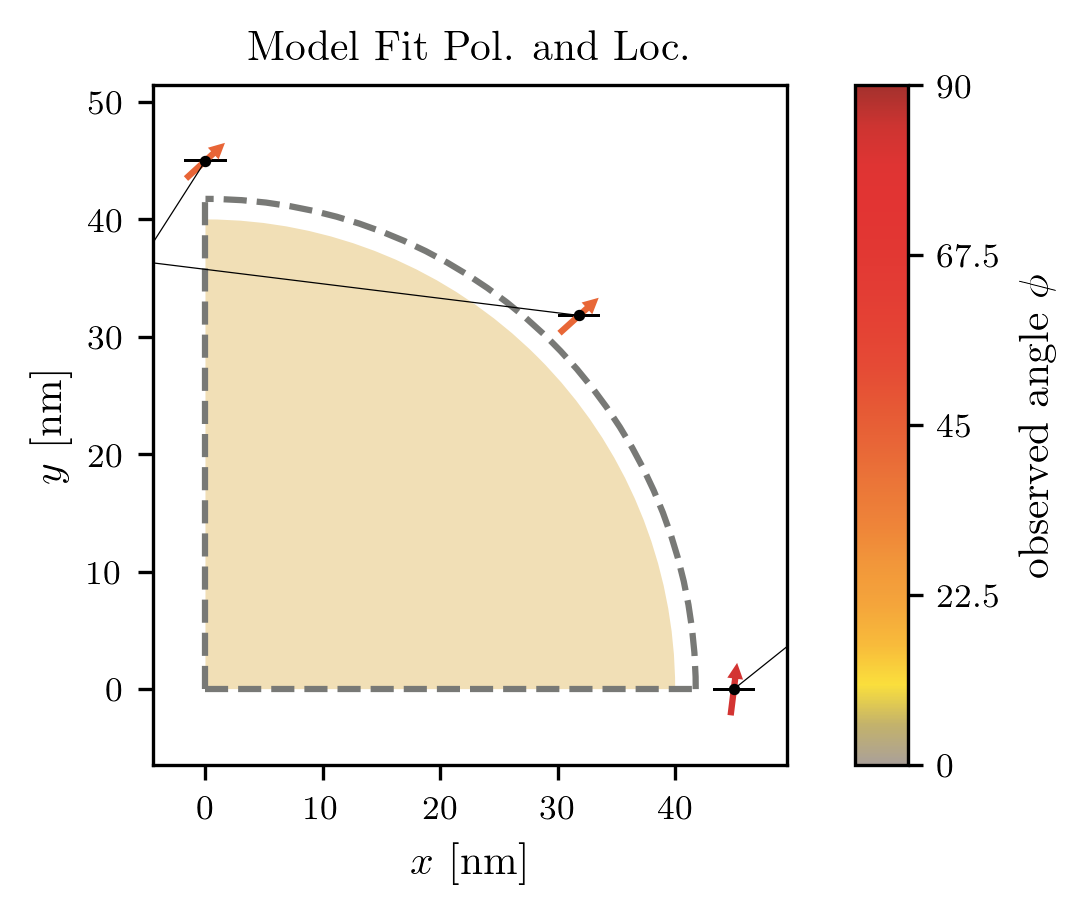

In [10]:
fit_inst_JC.plot_fit_results_as_quiver_map(sim_inst_JC)   